In [1]:
%load_ext autoreload
%autoreload 2

# After following the installation (or building from source) instructions,
# you should be able to import jaxquantum without having to add it to
# your path explicitly. 

In [2]:
import jaxquantum as jqt
from jax import jit
import jax.numpy as jnp
import matplotlib.pyplot as plt


omega_q = 5.0 #GHz
Omega = .1
g_state = jqt.ket2dm(jqt.basis(2,0)) + 0.0j
ts = jnp.linspace(0,jnp.pi/Omega,101)
c_ops = jnp.array([])

@jit
def Ht(t):
    H0 = omega_q/2.0*jqt.sigmaz()
    H1 = Omega*jnp.cos((omega_q+0.0j)*t)*jqt.sigmax()
    return H0 + H1

states = jqt.mesolve(g_state, ts, c_ops=c_ops, Ht=Ht, use_density_matrix=True) 
szt = jnp.real(jqt.calc_expect(jqt.sigmaz(), states))

In [3]:
%timeit states = jqt.mesolve(g_state, ts, c_ops=c_ops, Ht=Ht, use_density_matrix=True) 

2.92 ms ± 35.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


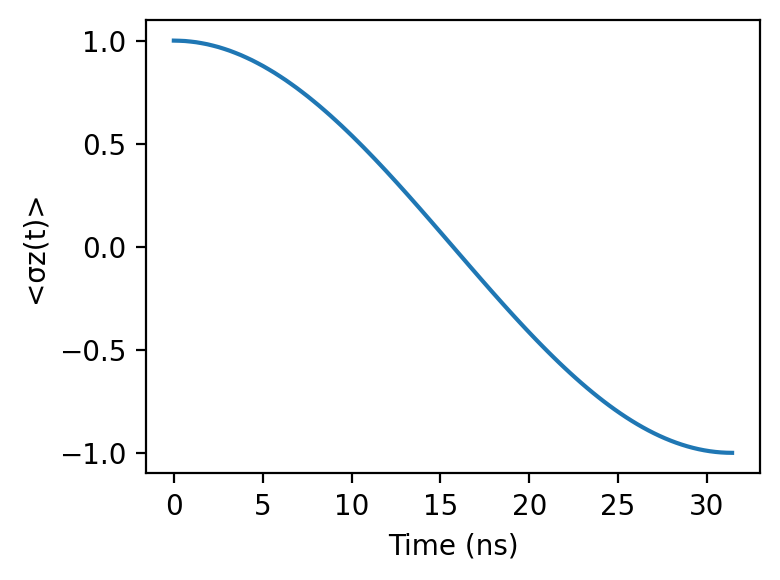

In [4]:
fig, ax = plt.subplots(1, dpi=200, figsize=(4,3))
ax.plot(ts, szt)
ax.set_xlabel("Time (ns)")
ax.set_ylabel("<σz(t)>")
fig.tight_layout()